In [3]:
from PIL import Image
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import torch
import tensorflow as tf
import random
from ultralytics import YOLO
import matplotlib
import cv2
import os
from os import listdir
from os.path import isfile, join

In [24]:
TRAIN_DIR = 'Emotions/train'
TEST_DIR = "Emotions/test"
batch_size = 64
img_height, img_width = 224, 224

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    labels='inferred',
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    validation_split=0.2,
    labels='inferred',
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, shuffle=True)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 7178 files belonging to 7 classes.
Using 1435 files for validation.


In [26]:
#Number of emotions
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [187]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
i = tf.keras.layers.Input(shape=[img_width, img_height, 3], dtype=tf.uint8)
x = tf.cast(i, tf.float32)

pretrained = tf.keras.applications.resnet50.ResNet50(input_shape=(img_width, img_height, 3), include_top=False,
                                                     weights="imagenet",
                                                     classes=num_classes, classifier_activation="softmax")
model = tf.keras.models.Sequential([
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_69 (Dense)            (None, 256)               524544    
                                                                 
 dense_70 (Dense)            (None, 64)                16448     
                                                                 
 dense_71 (Dense)            (None, 7)                 455       
                                                                 
Total params: 24,129,159
Trainable params: 24,076,039
Non-trainable params: 53,120
____________________________________

In [189]:
callbacks = tf.keras.callbacks.ModelCheckpoint("emotion.h5", save_best_only=True)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20


2023-02-09 03:48:34.884310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.5041

2023-02-09 03:52:10.083055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 224s 598ms/step - loss: 1.3052 - accuracy: 0.5041 - val_loss: 1.6716 - val_accuracy: 0.3512
Epoch 2/20
359/359 [==============================] - 223s 620ms/step - loss: 1.0932 - accuracy: 0.5859 - val_loss: 1.5224 - val_accuracy: 0.4167
Epoch 3/20
359/359 [==============================] - 227s 629ms/step - loss: 0.9745 - accuracy: 0.6356 - val_loss: 1.7653 - val_accuracy: 0.3498
Epoch 4/20
359/359 [==============================] - 228s 633ms/step - loss: 0.8678 - accuracy: 0.6726 - val_loss: 1.4022 - val_accuracy: 0.5296
Epoch 5/20
359/359 [==============================] - 227s 630ms/step - loss: 0.7671 - accuracy: 0.7141 - val_loss: 1.4871 - val_accuracy: 0.5226
Epoch 6/20
359/359 [==============================] - 223s 617ms/step - loss: 0.6571 - accuracy: 0.7593 - val_loss: 1.6822 - val_accuracy: 0.4634
Epoch 7/20
359/359 [==============================] - 220s 611ms/step - loss: 0.5352 - accuracy: 0.8065 - val_loss: 1.6674 - val_accura

In [190]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.305162,0.504136,1.671572,0.351220
1,1.093171,0.585902,1.522427,0.416725
2,0.974486,0.635624,1.765332,0.349826
3,0.867841,0.672588,1.402158,0.529617
4,0.767117,0.714124,1.487130,0.522648
5,0.657107,0.759274,1.682172,0.463415
6,0.535215,0.806470,1.667420,0.484321
7,0.443541,0.839472,1.565200,0.520558
8,0.339192,0.877699,2.150149,0.466899
9,0.264957,0.904824,2.339977,0.444599


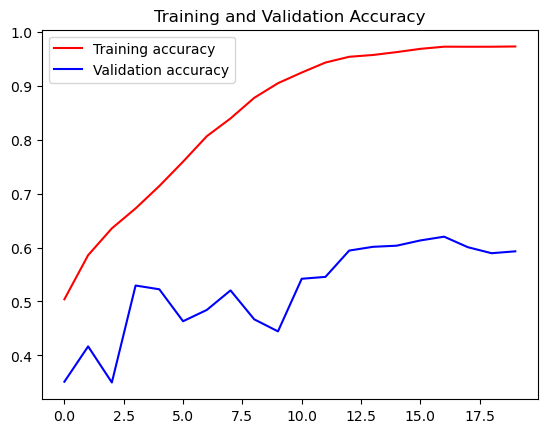

<Figure size 640x480 with 0 Axes>

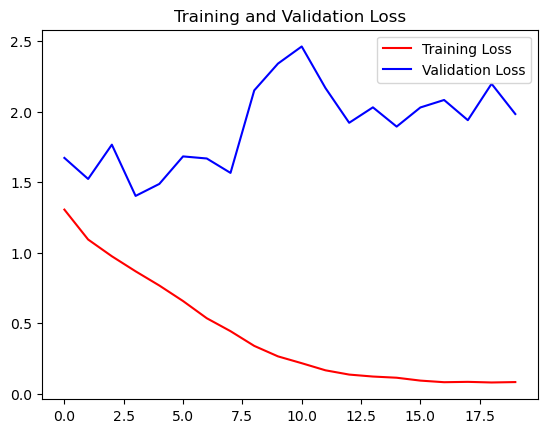

<Figure size 640x480 with 0 Axes>

In [196]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

IndexError: tuple index out of range

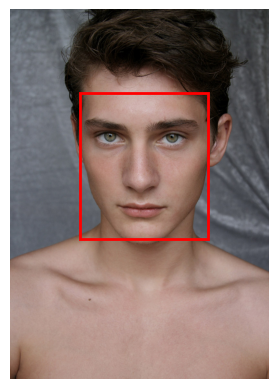

In [26]:
#YOLOv8 start!

images_path = "Human Faces/Images"
annotations_path = "Human Faces/Labels"


def print_random_images(photos: list, n: int = 5) -> None:
    if n > 10:
        n = 10
    for im in range(n):
        random_photo = random.choice(photos)
        random_photo_path = str(images_path) + '/' + str(random_photo)

        with Image.open(random_photo_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)
            ax.axis(False)
            image_width, image_height = fd.size

        file = random_photo[:random_photo.index(".")] + '.txt'
        annotation_file = annotations_path + "/" + file
        with open(annotation_file) as f:
            label = f.read()

        labels = label.split(" ")
        labels[4] = labels[4][:-1]
        labels = list(map(float, labels))

        x1, y1, width, height = labels[1:]
        bbox_x = x1 * image_width - image_width * width / 2
        bbox_y = y1 * image_height - image_height * height / 2
        bbox_width = width * image_width
        bbox_height = height * image_height

        mpatch = matplotlib.patches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_height, linewidth=1, edgecolor='r',
                                              facecolor="none", lw=2)
        ax.add_patch(mpatch)
        rx, ry = mpatch.get_xy()
        ax.annotate('Face', (rx, ry - 2), color='red', weight='bold', fontsize=12, ha='left', va='baseline')


photos_list = [f for f in listdir(images_path) if isfile(join(images_path, f))]
print_random_images(photos_list)

In [246]:
import splitfolders

input_folder = "Human Faces/"
output_folder = "Human Faces/Training"
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.8, 0.2), group_prefix=None, move=False)

Copying files: 1582 files [00:01, 898.14 files/s] 
Copying files: 1582 files [00:00, 3820.53 files/s]


In [283]:
from ultralytics import YOLO
import time

start = time.time()
model = YOLO("yolov8n.yaml")
model.train(data="faces.yaml", epochs=50)
end = time.time()
elapsed_time = end - start
print(f"Elapsed Time: {elapsed_time}")


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

Elapsed Time: 15723.880965948105


In [285]:
model.val()

Ultralytics YOLOv8.0.31 🚀 Python-3.10.8 torch-1.13.1 CPU
val: Scanning /Users/king/Desktop/CV DL/yolov8/yolo/datasets/Human Faces/Training/val/labels.cache... 159 images, 0 backgrounds, 0 corrupt: 100%|██████████| 159/159 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.80s/it]
                   all        159        159      0.994      0.981      0.995      0.721
                  face        159        159      0.994      0.981      0.995      0.721
Speed: 0.5ms pre-process, 154.2ms inference, 0.0ms loss, 0.2ms post-process per image


In [4]:

model = YOLO("best.pt")
result = model("testfiles/happy.jpg")

Ultralytics YOLOv8.0.31 🚀 Python-3.10.8 torch-1.13.1 CPU
YOLOv8n summary (fused): 168 layers, 3008768 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /Users/king/Desktop/CV DL/HumanEmotions/testfiles/happy.jpg: 448x640 1 face, 56.5ms
Speed: 0.6ms pre-process, 56.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [16]:
#convert tf model to pytorch for inference
#tf to onnx
import tf2onnx
import tensorflow as tf

# Load the TensorFlow model
model = tf.keras.models.load_model('emotion.h5')
tf2onnx.convert.from_keras(model, output_path="emotion.onnx")

Metal device set to: Apple M1 Max


In [18]:
#onnx to pytorch
import onnx
import torch
from onnx2torch import convert

onnx_model = onnx.load("emotion.onnx")
pytorch_model = convert(onnx_model)


In [28]:
yolo_model = torch.hub.load("yolov8n.pt", "custom", path="best.pt", force_reload=True)

ValueError: not enough values to unpack (expected 2, got 1)

In [12]:
model1 = tf.keras.models.load_model("emotion.h5")
model2 = YOLO("best.pt")
# results = model2(source="0", show=True)

In [ ]:
import cv2
video = cv2.VideoCapture(0)
while True:
    retu, frame = video.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    results = model2(frame)
    print(results)
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    width, height = frame.shape[1], frame.shape[0]
    cv2.imshow("frame",frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

In [40]:
from skimage import transform
filename = "testfiles/happy.jpg"
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image
res = model1.predict(load(filename))
res[0]


1/1 [==============================] - 0s 30ms/step


array([    0.27904,    0.023882,     0.21113,     0.19183,    0.082054,    0.077972,     0.13409], dtype=float32)